In [1]:
from fastai.vision.all import *
from fastai.callback.wandb import WandbCallback
import wandb
import timm, fastai

In [2]:
timm.__version__, fastai.__version__

('0.3.4', '2.2.5')

### NIH Chest14 Dataset

[Kaggle Dataset Link](https://www.kaggle.com/nih-chest-xrays/data)

In [3]:
datapath = Path("../../data/nih-cxr/")

In [4]:
print(sorted(datapath.ls().map(lambda o: o.name)))

['ARXIV_V5_CHESTXRAY.pdf', 'BBox_List_2017.csv', 'Data_Entry_2017.csv', 'FAQ_CHESTXRAY.pdf', 'LOG_CHESTXRAY.pdf', 'README_CHESTXRAY.pdf', 'images_001', 'images_002', 'images_003', 'images_004', 'images_005', 'images_006', 'images_007', 'images_008', 'images_009', 'images_010', 'images_011', 'images_012', 'test_list.txt', 'train_val_list.txt']


In [5]:
train_val_fns = L(np.loadtxt(datapath/'train_val_list.txt', dtype=str).tolist())
test_fns = L(np.loadtxt(datapath/'test_list.txt', dtype=str).tolist())

In [6]:
train_val_fns, test_fns

((#86524) ['00000001_000.png','00000001_001.png','00000001_002.png','00000002_000.png','00000004_000.png','00000005_000.png','00000005_001.png','00000005_002.png','00000005_003.png','00000005_004.png'...],
 (#25596) ['00000003_000.png','00000003_001.png','00000003_002.png','00000003_003.png','00000003_004.png','00000003_005.png','00000003_006.png','00000003_007.png','00000013_000.png','00000013_001.png'...])

In [7]:
all_image_files = []
for o in datapath.ls().filter(lambda o: o.name.startswith("images")): all_image_files.extend(get_image_files(o))

In [8]:
len(all_image_files)

112120

In [9]:
train_val_fns, test_fns = set(train_val_fns), set(test_fns)

In [10]:
train_val_files = L(all_image_files).filter(lambda o: o.name in train_val_fns)
test_val_files = L(all_image_files).filter(lambda o: o.name in test_fns)

In [11]:
len(train_val_files), len(test_val_files)

(86524, 25596)

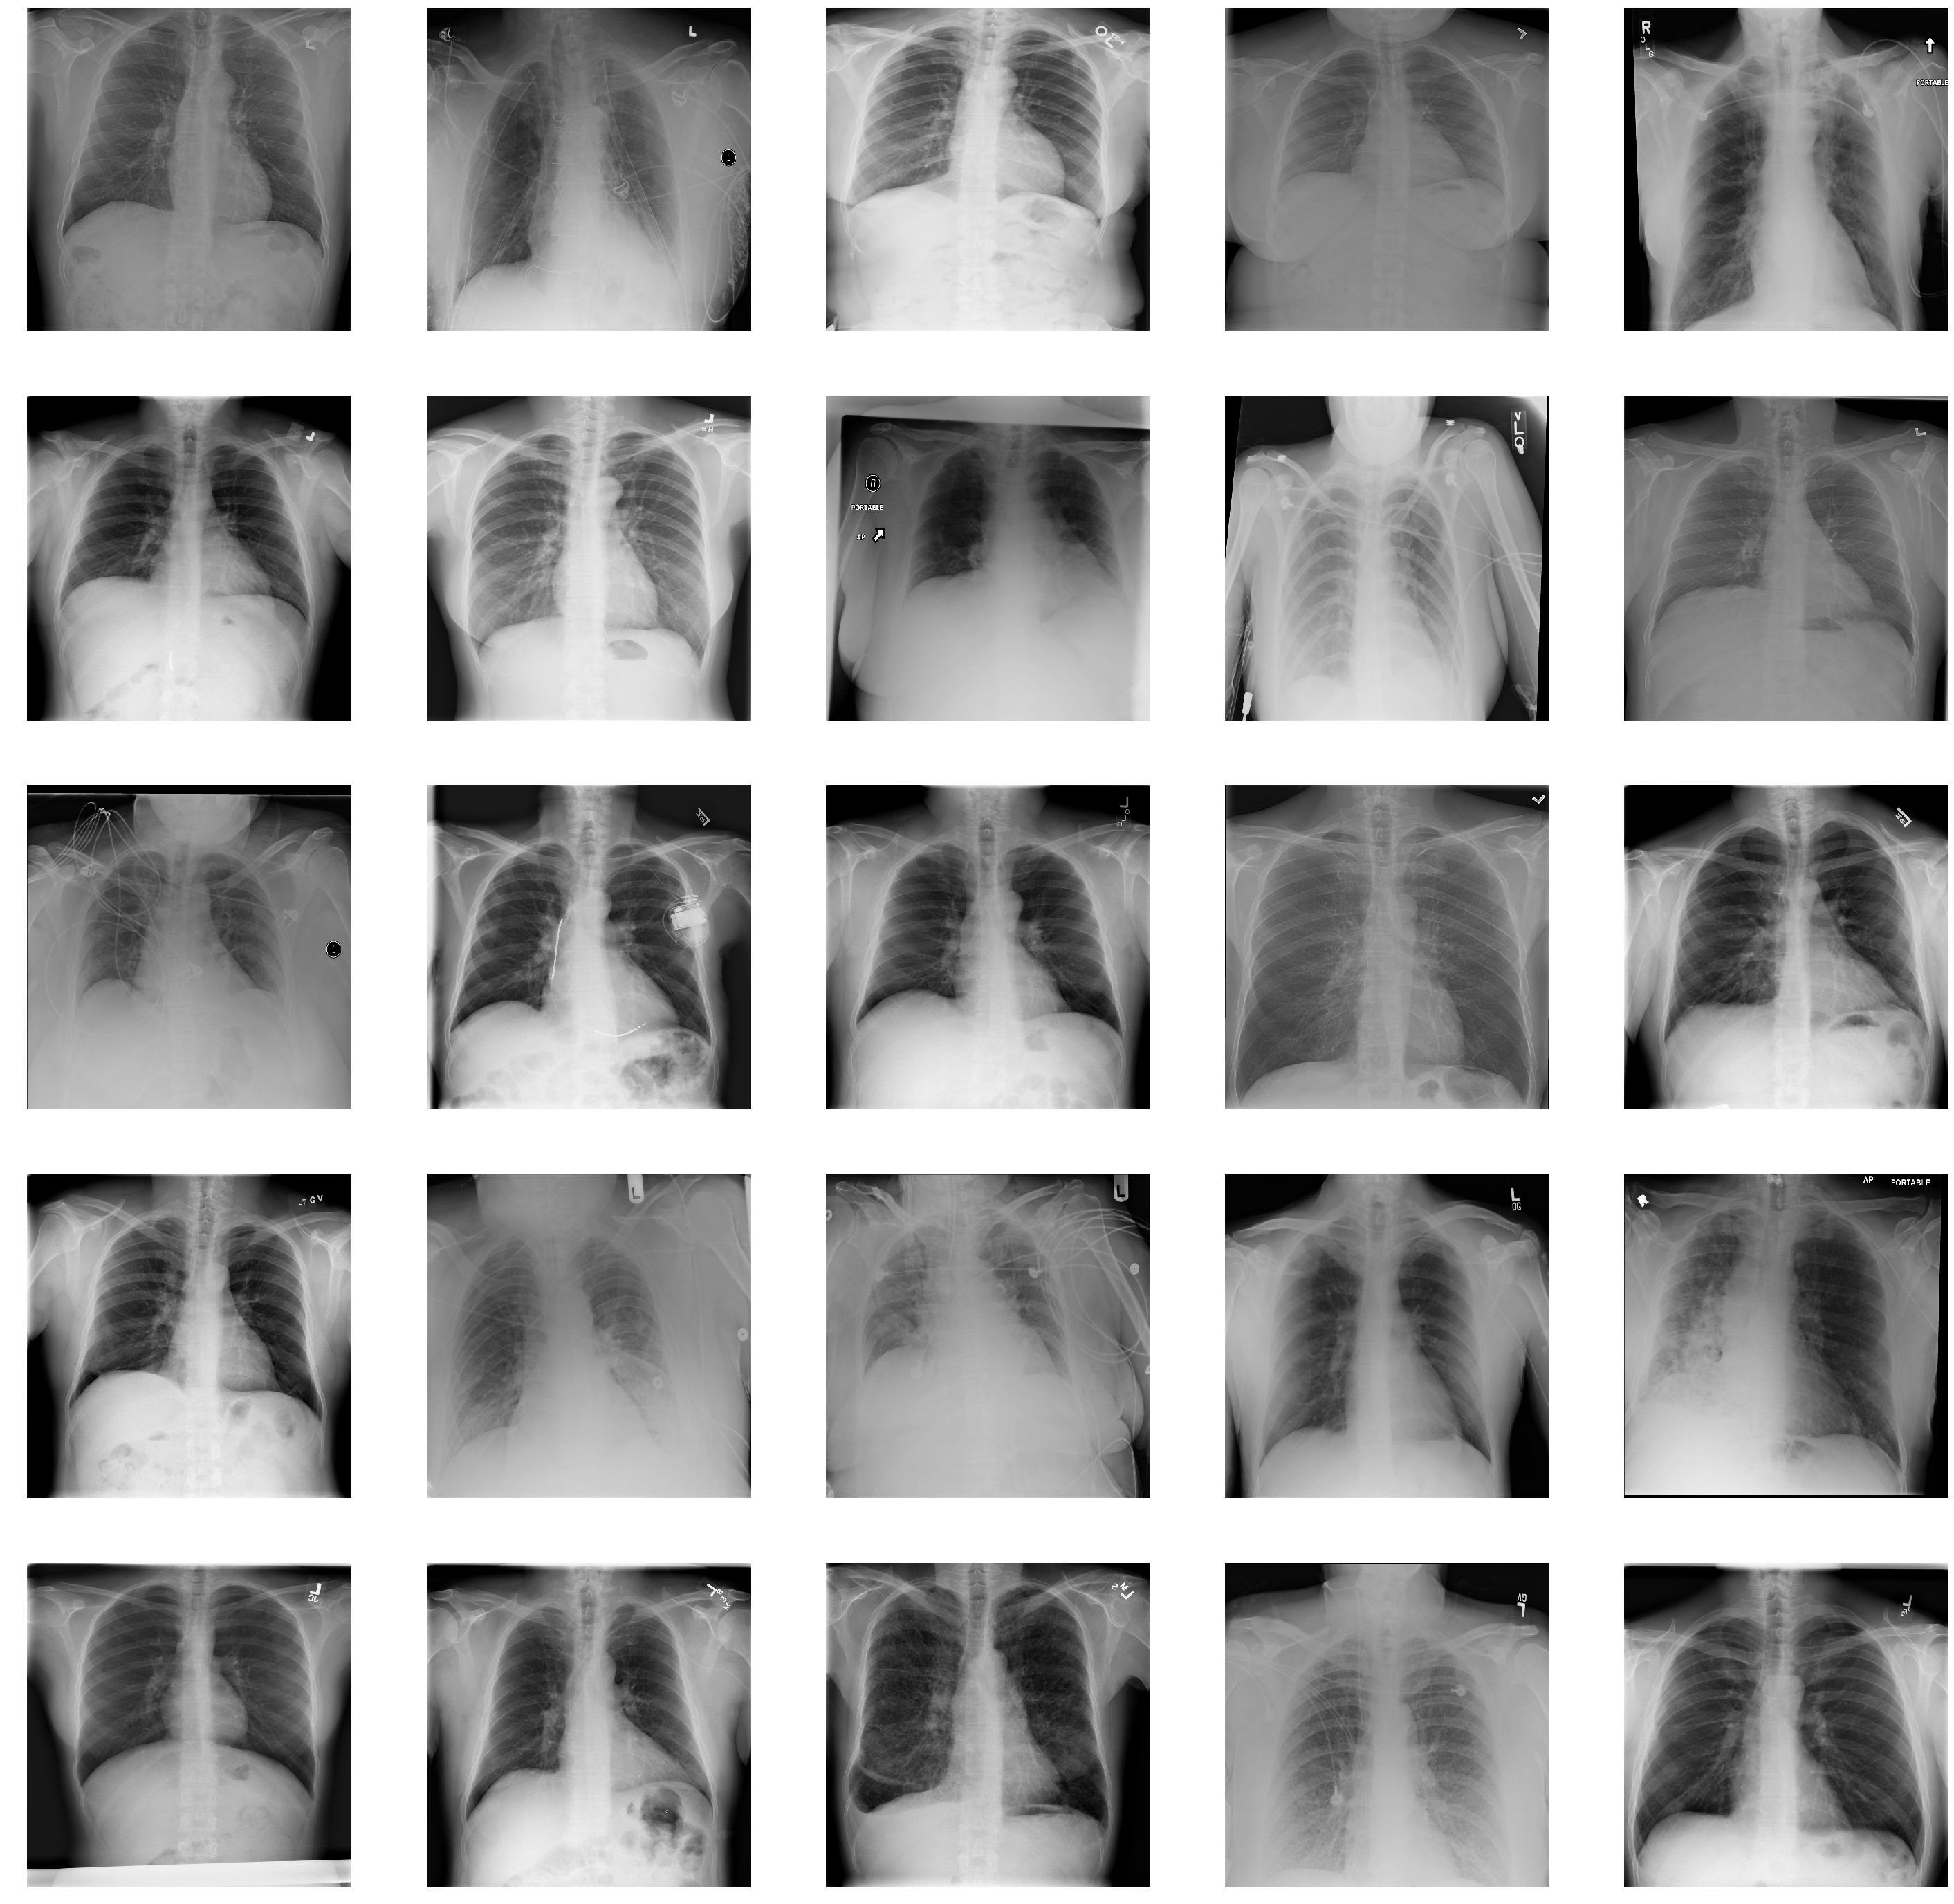

In [11]:
show_images(L(np.random.choice(train_val_files, 25).tolist()).map(PILImage.create),nrows=5,figsize=(50,50))

### Data Split

In [12]:
np.random.seed(42)

In [13]:
shuffled_files = np.random.permutation(train_val_files)
sup_files = shuffled_files[:15000]
unsup_files = shuffled_files[15000:]

In [14]:
len(sup_files), len(unsup_files)

(15000, 71524)

### 1. Pretraining (SwAV)

In [15]:
from self_supervised.augmentations import *
from self_supervised.layers import *
from self_supervised.swav import *

In [16]:
from kornia.augmentation import RandomEqualize
from torchvision import transforms as tvtfm
from kornia import augmentation as korniatfm

In [17]:
def get_cxr_batch_augs(size,
                        rotate=True,
                        jitter=False,
                        bw=False,
                        blur=True,
                        equalize=True,
                        resize_scale=(0.3, 1.0),
                        resize_ratio=(4/5, 5/4),
                        rotate_deg=30,
                        s=.6,  
                        blur_s=(4,32),
                        same_on_batch=False,
                        flip_p=0.5, rotate_p=0.5, jitter_p=0.3, bw_p=0.3, blur_p=0.5, eqlz_p=0.5,
                        stats=imagenet_stats,
                        cuda=default_device().type == 'cuda',
                        xtra_tfms=[]):
    "Input batch augmentations implemented in tv+kornia+fastai"
    tfms = []
    tfms += [tvtfm.RandomResizedCrop((size, size), scale=resize_scale, ratio=resize_ratio)]
    tfms += [korniatfm.RandomHorizontalFlip(p=flip_p)]

    if rotate: tfms += [Rotate(max_deg=rotate_deg, p=rotate_p, batch=same_on_batch)]

    if jitter:   tfms += [korniatfm.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s, p=jitter_p, same_on_batch=same_on_batch)]
    if bw:       tfms += [korniatfm.RandomGrayscale(p=bw_p, same_on_batch=same_on_batch)]   
    if blur:     tfms += [RandomGaussianBlur(p=blur_p, s=blur_s, same_on_batch=same_on_batch)]
    if equalize: tfms += [RandomEqualize(p=eqlz_p, same_on_batch=same_on_batch)]
        
    if stats is not None: tfms += [Normalize.from_stats(*stats, cuda=cuda)]

    tfms += xtra_tfms
    pipe = Pipeline(tfms, split_idx = 0)
    return pipe

In [18]:
# Resize from 1024x1024 to 512x512
resize = 512
size = int(resize/1.6)
bs = 24
tfms = [[PILImage.create,  Resize((resize,resize)), ToTensor()]]
dsets = Datasets(train_val_files, tfms=tfms, n_inp=1, splits=RandomSplitter(valid_pct=0.1)(train_val_files))
batch_tfms = [IntToFloatTensor]
dls = dsets.dataloaders(bs=bs, num_workers=4, after_batch=batch_tfms)

In [19]:
resize, size

(512, 320)

In [20]:
arch = "resnet101d_320"
encoder = create_encoder(arch, pretrained=True, n_in=3)

xtra_config = {"Arch":arch, "Resize":resize, "Size":size, "Algorithm":"SWAV"}
wandb.init(project="self-supervised-nih-cxr", config=xtra_config);

# Use 320 large and 240 small crops
model = create_swav_model(encoder, n_in=3)
learn = Learner(dls, model, SWAVLoss(),
                cbs=[SWAV(aug_func=get_cxr_batch_augs,
                          crop_sizes=[size,int(1/2*size)],
                          num_crops=[2,4],
                          min_scales=[0.5,0.3],
                          max_scales=[1.0,0.5],                
                          rotate=True,
                          jitter=False,
                          bw=False,
                          blur=True,
                          equalize=True,
                          rotate_deg=30,
                          s=.6,  
                          blur_s=(4,16),
                          same_on_batch=False,
                          flip_p=0.5, rotate_p=0.5, eqlz_p=0.5, blur_p=0.3,
                          stats=imagenet_stats),
                     TerminateOnNaNCallback(),
                     WandbCallback(log_preds=False,log_model=False),
                     GradientAccumulation(n_acc=48)
                     ])

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Currently logged in as: keremturgutlu (use `wandb login --relogin` to force relogin)


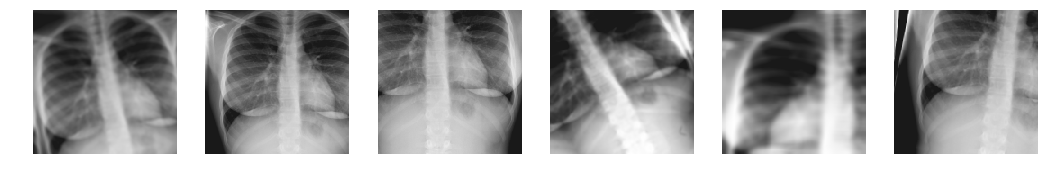

In [26]:
b = dls.one_batch()
learn._split(b)
learn('before_batch')
learn.swav.show_one()

In [ ]:
learn.load("swav_nih_cxr_resize448_size280_epc30") # load previous model
lr=1e-2
wd=1e-2
epochs=40

learn.to_fp16()
learn.unfreeze()
learn.fit_flat_cos(epochs, lr, wd=wd, pct_start=0.5)

wandb.finish()

In [ ]:
learn.save(f"swav_nih_cxr_resize{resize}_size{size}_epc{epochs}")
torch.save(encoder_state_dict, f"./models/swav_nih_cxr_resize{resize}_size{size}_epc{epochs}_encoder.pth")

### Baseline Training

Take random 20,000 images for training with and without pretrained weights

In [12]:
from self_supervised.layers import *

In [13]:
random_train_val_files = L(np.random.permutation(train_val_files)[:10000].tolist())

In [14]:
print(sorted(datapath.ls().map(lambda o: o.name)))

['ARXIV_V5_CHESTXRAY.pdf', 'BBox_List_2017.csv', 'Data_Entry_2017.csv', 'FAQ_CHESTXRAY.pdf', 'LOG_CHESTXRAY.pdf', 'README_CHESTXRAY.pdf', 'images_001', 'images_002', 'images_003', 'images_004', 'images_005', 'images_006', 'images_007', 'images_008', 'images_009', 'images_010', 'images_011', 'images_012', 'test_list.txt', 'train_val_list.txt']


In [15]:
labels_df = pd.read_csv(datapath/'Data_Entry_2017.csv')

In [16]:
labels_df.head()

Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0                        0.143  0.143          NaN  
1                        0.143  0.143          NaN  
2                        0.168  0.168          NaN  
3                        0.171  0.171          NaN  
4                        0.143  0.143          NaN

In [17]:
img2labels = dict(zip(labels_df['Image Index'], labels_df['Finding Labels'].apply(lambda o:o.split('|'))))
def read_labels(o): return [o for o in img2labels[o.name] if o != 'No Finding']

In [18]:
random_train_val_files

(#10000) [Path('../../data/nih-cxr/images_006/images/00012935_024.png'),Path('../../data/nih-cxr/images_012/images/00029688_001.png'),Path('../../data/nih-cxr/images_011/images/00027236_001.png'),Path('../../data/nih-cxr/images_007/images/00015031_011.png'),Path('../../data/nih-cxr/images_007/images/00015369_000.png'),Path('../../data/nih-cxr/images_007/images/00013903_000.png'),Path('../../data/nih-cxr/images_007/images/00015661_000.png'),Path('../../data/nih-cxr/images_008/images/00017748_000.png'),Path('../../data/nih-cxr/images_003/images/00005110_003.png'),Path('../../data/nih-cxr/images_003/images/00004737_015.png')...]

In [20]:
# Resize from 1024x1024 to 512x512
resize = 448
size = int(resize/1.6)
bs = 32
tfms = [[PILImage.create,  Resize((resize,resize)), ToTensor()], [read_labels, MultiCategorize(vocab=None, add_na=None), OneHotEncode]]
dsets = Datasets(random_train_val_files, tfms=tfms, n_inp=1, splits=RandomSplitter(valid_pct=0.3, seed=42)(random_train_val_files))
batch_tfms = [IntToFloatTensor, RandomResizedCrop(size), Normalize.from_stats(*imagenet_stats)]
dls = dsets.dataloaders(bs=bs, num_workers=4, after_batch=batch_tfms)

In [21]:
len(dls.train_ds), len(dls.valid_ds), dls.c

(7000, 3000, 14)

In [22]:
dls.multi_categorize.vocab

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

In [23]:
arch = "resnet101d_320"
xtra_config = {"Arch":arch, "Resize":resize, "Size":size}
with wandb.init(project="self-supervised-nih-cxr", config=xtra_config):
    model = create_model(arch, dls.c)
    learn = Learner(dls, model, opt_func=ranger, splitter=_splitter, metrics=[RocAucMulti()],
                    cbs=[TerminateOnNaNCallback(),
                         WandbCallback(log_preds=False,log_model=False)])
    learn.unfreeze()
    learn.to_fp16();
    learn.fit_flat_cos(2, 1e-2)

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Currently logged in as: keremturgutlu (use `wandb login --relogin` to force relogin)


In [24]:
preds, targs = learn.get_preds()
preds, targs = to_np(preds), to_np(targs)

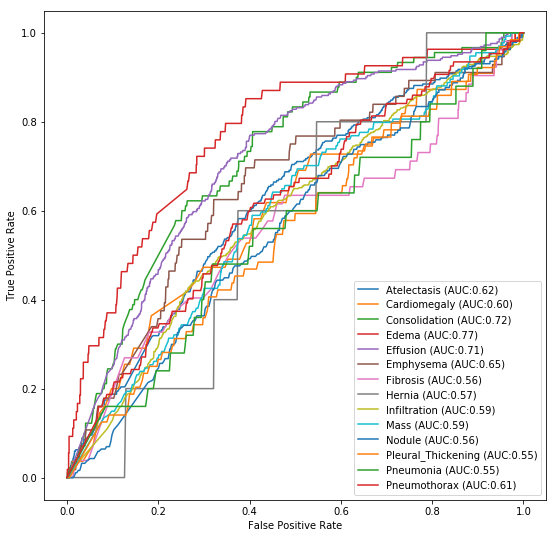

In [25]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(dls.vocab):
    fpr, tpr, thresholds = roc_curve(targs[:,idx].astype(int), preds[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')

### Finetuning

Take random 10,000 (30% validation) images for training with and without pretrained weights

In [26]:
# Resize from 1024x1024 to 512x512
resize = 448
size = int(resize/1.6)
bs = 32
tfms = [[PILImage.create,  Resize((resize,resize)), ToTensor()], [read_labels, MultiCategorize(vocab=None, add_na=None), OneHotEncode]]
dsets = Datasets(random_train_val_files, tfms=tfms, n_inp=1, splits=RandomSplitter(valid_pct=0.3, seed=42)(random_train_val_files))
batch_tfms = [IntToFloatTensor, RandomResizedCrop(size), Normalize.from_stats(*imagenet_stats)]
dls = dsets.dataloaders(bs=bs, num_workers=4, after_batch=batch_tfms)

In [27]:
resize, size, len(dls.train_ds), len(dls.valid_ds), dls.c

(448, 280, 7000, 3000, 14)

In [28]:
dls.multi_categorize.vocab

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

In [29]:
encoder_state_dict = torch.load("./models/swav_nih_cxr_resize448_size280_epc30_encoder.pth")

In [30]:
arch = "resnet101d_320"
xtra_config = {"Arch":arch, "Resize":resize, "Size":size}
with wandb.init(project="self-supervised-nih-cxr", config=xtra_config):
    model = create_model(arch, dls.c)
    model[0].load_state_dict(encoder_state_dict)    
    learn = Learner(dls, model, opt_func=ranger, splitter=_splitter, metrics=[RocAucMulti()],
                    cbs=[TerminateOnNaNCallback(),
                         WandbCallback(log_preds=False,log_model=False)])
    learn.unfreeze()
    learn.to_fp16();
    learn.fit_flat_cos(2, 1e-2)

In [31]:
preds, targs = learn.get_preds()
preds, targs = to_np(preds), to_np(targs)

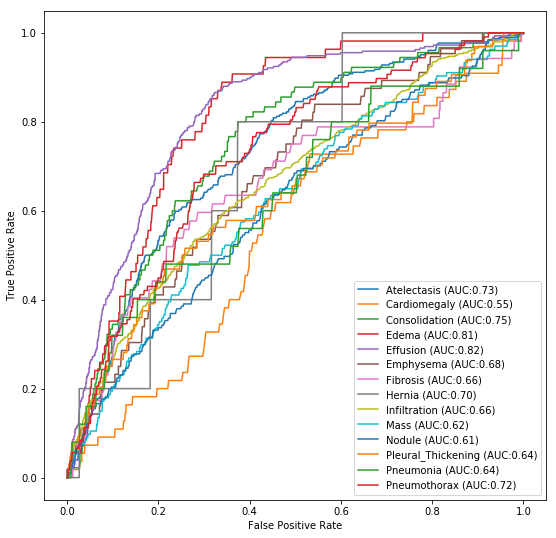

In [32]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(dls.vocab):
    fpr, tpr, thresholds = roc_curve(targs[:,idx].astype(int), preds[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')